In [1]:
#Code Block 1
import numpy as np
import pandas as pd
import os
from tqdm import tqdm, tqdm_pandas
import multiprocessing as mp



In [2]:
#Code Block 2
#For Preprocessing
import re
import string
import nltk
nltk.download("stopwords")
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
#Code Block 3
# For Building the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses
import tensorflow.keras.backend as K



In [4]:
#Code Block 4
#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
%matplotlib inline
pd.options.plotting.backend = "plotly"
warnings.filterwarnings('ignore')
tqdm_pandas(tqdm()) # tqdm.pandas()

RS = 42

0it [00:00, ?it/s]


# Data Read & Preprocessing

In [5]:
#Code Block 5
def parallelize_dataframe(df, func):
    num_processes = mp.cpu_count()
    df_split = np.array_split(df, num_processes)
    with mp.Pool(num_processes) as p:
        df = pd.concat(p.map(func, df_split))
    return df



In [6]:
#Code Block 6
def main_preprocessing(tweet):
    def remove_urls(tweet):
        return re.sub(r"http(s?)://[\S]+", '', tweet)

    def remove_at_links(tweet):
        return re.sub(r"\B(@)\S+", '', tweet)
    
    def remove_non_ascii_chars(tweet):
        ascii_chars = set(string.printable)
        for c in tweet:
            if c not in ascii_chars:
                tweet = tweet.replace(c,'')
        return tweet

    def remove_emojis(tweet):
            emoj = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002500-\U00002BEF"  # chinese char
                u"\U00002702-\U000027B0"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U00010000-\U0010ffff"
                u"\u2640-\u2642" 
                u"\u2600-\u2B55"
                u"\u200d"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\ufe0f"
                u"\u3030"
                u"\u23f0"
                u"\u23f1"
                u"\u23f2"
                u"\u23f3"
                              "]+", re.UNICODE)
            return re.sub(emoj, '', tweet)

    def fix_ax_nots(tweet):
        tweet = tweet.replace(" dont ", " do not ")
        tweet = tweet.replace(" don't ", " do not ")
        tweet = tweet.replace(" doesnt ", " does not ")
        tweet = tweet.replace(" doesn't ", " does not ")
        tweet = tweet.replace(" wont ", " will not ")
        tweet = tweet.replace(" won't ", " will not ")
        tweet = tweet.replace(" cant ", " cannot ")
        tweet = tweet.replace(" can't ", " cannot ")
        tweet = tweet.replace(" couldnt ", " could not ")
        tweet = tweet.replace(" couldn't ", " could not ")
        tweet = tweet.replace(" shouldnt ", " should not ")
        tweet = tweet.replace(" shouldn't ", " should not ")
        tweet = tweet.replace(" wouldnt ", " would not ")
        tweet = tweet.replace(" wouldn't ", " would not ")
        tweet = tweet.replace(" mustnt ", " must not ")
        tweet = tweet.replace(" mustn't ", " must not ")
        return tweet

    def fix_personal_pronouns_and_verb(tweet):
        tweet = tweet.replace(" im ", " i am ")
        tweet = tweet.replace(" youre ", " you are")
        tweet = tweet.replace(" hes ", " he is") # ? he's can be he has as well
        tweet = tweet.replace(" shes ", " she is")
        tweet = tweet.replace(" theyre ", " they are")
        tweet = tweet.replace(" ive ", " i have ")
        tweet = tweet.replace(" youve ", " you have ")
        tweet = tweet.replace(" weve ", " we have ")
        tweet = tweet.replace(" theyve ", " they have ")
        tweet = tweet.replace(" youll ", " you will ")
        tweet = tweet.replace(" theyll ", " they will ")
        return tweet

    def fix_special_chars(tweet):
        tweet = tweet.replace("&amp;", " and ").replace("#", " ")
        tweet = re.sub(r'\(\d+/\d+\)|(\d/)', '', tweet)
        return tweet
    
    try:
        tweet = tweet.lower()
        tweet = remove_emojis(tweet)
        tweet = remove_urls(tweet)
        tweet = remove_at_links(tweet)
        tweet = remove_non_ascii_chars(tweet)
        tweet = fix_special_chars(tweet)
        tweet = fix_ax_nots(tweet)
        tweet = fix_personal_pronouns_and_verb(tweet)
    except:
        tweet = np.nan
    return tweet


In [7]:
#Code Block 7
def async_main_preprocessing(data):
    data = data[['text']]
    data['cleantext'] = data.progress_apply(lambda x: main_preprocessing(x['text']), axis = 1)
    data = data.dropna()
    return data


In [8]:
#Code Block 8
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    try:
        tweet = re.sub(r"[^a-zA-Z0-9]", " ", tweet)
        words = tweet.split()
        words = [w for w in words if w not in stopwords.words("english")]
        words = [PorterStemmer().stem(w) for w in words]
    except:
        words=['None']
    return words


In [9]:
#Code Block 9
def async_tweet_to_words(data):
    data['words'] = data.progress_apply(lambda x: tweet_to_words(x['cleantext']), axis = 1)
    return data

In [10]:
#Code Block 10
df = pd.read_csv('Bitcoin_tweets.csv',error_bad_lines=False)
print(f'Data Size: {df.shape[0]}x{df.shape[1]}')
df.head()

Data Size: 1232809x13


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


## Sampling

In [11]:
#Code Block 11
df = df.sample(int(5e+5), random_state = RS,replace=True)
print(f'Data Size: {df.shape[0]}x{df.shape[1]}')
df.head()

Data Size: 500000x13


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
121958,Satoshi Milk,Milky Way,got #bitcoin?® ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀ ⠀ ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀...,2019-07-17 02:07:50,28.0,146.0,2457.0,False,2021-05-26 17:23:12,Do you have some cash saved to buy the everyth...,"['Crpyto', 'Stocks', 'Bitcoin', 'RealEstate', ...",Twitter for iPhone,False
671155,Sibongile Dlamini,NaN,NaN,2020-05-08 00:11:05,137.0,103,7409,False,2021-07-27 17:31:38,@doubletop_io Buy #DBA Token while on private ...,"['DBA', 'DafriBankDigital', 'SAFEBANKYES', 'BT...",Twitter for Android,False
131932,Donald McIntyre ☢️🥩☘️🍊🌋,#ETCARMY HQ,"I research, write articles, and podcast about ...",2021-02-24 22:28:00,730.0,372.0,3386.0,False,2021-06-23 17:18:43,Nouriel is a noob and doesn't know anything ab...,['Bitcoin'],Twitter Web App,False
259178,"Bitcoin4all. Bullish, of course.",NaN,"Bitcoin enthousiast, former professional dance...",2021-03-29 17:18:06,132.0,296.0,6219.0,False,2021-07-05 18:47:07,@100trillionUSD I thought you went on vacation...,['Bitcoin'],Twitter for Android,False
110268,Bitcoin Price Now,Bitcoin,#Bitcoin price updates every 30 minutes #BTC #...,2017-07-04 14:12:13,3142.0,1419.0,336.0,False,2021-05-29 06:00:07,"May 29, 2021 05:59:00 UTC | 36,846.10$ | 30,22...","['Bitcoin', 'BTC', 'crypto', 'financial', 'news']",Bitcoin Price Now,False


In [12]:
#Code Block 12
df = parallelize_dataframe(df, async_main_preprocessing)
print(f'Data Size: {df.shape[0]}x{df.shape[1]}')
df.head()

250000it [18:36, 223.93it/s]  
250000it [18:37, 223.67it/s] 


Data Size: 499998x2


,text,cleantext
121958,Do you have some cash saved to buy the everyth...,do you have some cash saved to buy the everyth...
671155,@doubletop_io Buy #DBA Token while on private ...,buy dba token while on private sale at $0.3...
131932,Nouriel is a noob and doesn't know anything ab...,nouriel is a noob and does not know anything a...
259178,@100trillionUSD I thought you went on vacation...,i thought you went on vacation! \n\n bitcoin ...
110268,"May 29, 2021 05:59:00 UTC | 36,846.10$ | 30,22...","may 29, 2021 05:59:00 utc | 36,846.10$ | 30,22..."


In [13]:
#Code Block 13
df = parallelize_dataframe(df, async_tweet_to_words)
print(f'Data Size: {df.shape[0]}x{df.shape[1]}')
df.head()

249999it [44:05, 94.51it/s] 
249999it [44:06, 94.46it/s] 


Data Size: 499998x3


,text,cleantext,words
121958,Do you have some cash saved to buy the everyth...,do you have some cash saved to buy the everyth...,"[cash, save, buy, everyth, dip, crpyto, stock,..."
671155,@doubletop_io Buy #DBA Token while on private ...,buy dba token while on private sale at $0.3...,"[buy, dba, token, privat, sale, 0, 32, list, p..."
131932,Nouriel is a noob and doesn't know anything ab...,nouriel is a noob and does not know anything a...,"[nouriel, noob, know, anyth, money, econom, bi..."
259178,@100trillionUSD I thought you went on vacation...,i thought you went on vacation! \n\n bitcoin ...,"[thought, went, vacat, bitcoin, never, sleep]"
110268,"May 29, 2021 05:59:00 UTC | 36,846.10$ | 30,22...","may 29, 2021 05:59:00 utc | 36,846.10$ | 30,22...","[may, 29, 2021, 05, 59, 00, utc, 36, 846, 10, ..."


In [14]:
#Code Block 14
def unlist(list):
        words=''
        for item in list:
            words+=item+' '
        return words


In [15]:
#Code Block 15
def async_vader(data):
    label = 'words'
    sid = SentimentIntensityAnalyzer()
    data["vader_neg"] = data[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    data["vader_neu"] = data[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    data["vader_pos"] = data[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    data["vader_comp"] = data[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    data['cleantext2'] = data[label].apply(lambda x: unlist(x))
    return data

In [16]:
#Code Block 16
df = parallelize_dataframe(df, async_vader) 
df.head()

,text,cleantext,words,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
121958,Do you have some cash saved to buy the everyth...,do you have some cash saved to buy the everyth...,"[cash, save, buy, everyth, dip, crpyto, stock,...",0.000,0.758,0.242,0.4939,cash save buy everyth dip crpyto stock bitcoin...
671155,@doubletop_io Buy #DBA Token while on private ...,buy dba token while on private sale at $0.3...,"[buy, dba, token, privat, sale, 0, 32, list, p...",0.000,1.000,0.000,0.0000,buy dba token privat sale 0 32 list public sal...
131932,Nouriel is a noob and doesn't know anything ab...,nouriel is a noob and does not know anything a...,"[nouriel, noob, know, anyth, money, econom, bi...",0.167,0.833,0.000,-0.0516,nouriel noob know anyth money econom bitcoin
259178,@100trillionUSD I thought you went on vacation...,i thought you went on vacation! \n\n bitcoin ...,"[thought, went, vacat, bitcoin, never, sleep]",0.000,1.000,0.000,0.0000,thought went vacat bitcoin never sleep
110268,"May 29, 2021 05:59:00 UTC | 36,846.10$ | 30,22...","may 29, 2021 05:59:00 utc | 36,846.10$ | 30,22...","[may, 29, 2021, 05, 59, 00, utc, 36, 846, 10, ...",0.000,1.000,0.000,0.0000,may 29 2021 05 59 00 utc 36 846 10 30 220 20 2...


In [17]:
#Code Block 17
def class_giver(neg_score, pos_score):
    if neg_score > 0:
        return 0
    elif pos_score > 0:
        return 2
    else:
        return 1
    


In [18]:
#Code Block 18
def async_class_giver(data):
    data['class']= data.apply(lambda x: class_giver(x['vader_neg'], x['vader_pos']), axis = 1)
    return data

In [19]:
#Code Block 19
df = parallelize_dataframe(df, async_class_giver)
df = df.reset_index(drop = True)
df.head()

,text,cleantext,words,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class
0,Do you have some cash saved to buy the everyth...,do you have some cash saved to buy the everyth...,"[cash, save, buy, everyth, dip, crpyto, stock,...",0.000,0.758,0.242,0.4939,cash save buy everyth dip crpyto stock bitcoin...,2
1,@doubletop_io Buy #DBA Token while on private ...,buy dba token while on private sale at $0.3...,"[buy, dba, token, privat, sale, 0, 32, list, p...",0.000,1.000,0.000,0.0000,buy dba token privat sale 0 32 list public sal...,1
2,Nouriel is a noob and doesn't know anything ab...,nouriel is a noob and does not know anything a...,"[nouriel, noob, know, anyth, money, econom, bi...",0.167,0.833,0.000,-0.0516,nouriel noob know anyth money econom bitcoin,0
3,@100trillionUSD I thought you went on vacation...,i thought you went on vacation! \n\n bitcoin ...,"[thought, went, vacat, bitcoin, never, sleep]",0.000,1.000,0.000,0.0000,thought went vacat bitcoin never sleep,1
4,"May 29, 2021 05:59:00 UTC | 36,846.10$ | 30,22...","may 29, 2021 05:59:00 utc | 36,846.10$ | 30,22...","[may, 29, 2021, 05, 59, 00, utc, 36, 846, 10, ...",0.000,1.000,0.000,0.0000,may 29 2021 05 59 00 utc 36 846 10 30 220 20 2...,1


In [20]:
#Code Block 20
df['class'].value_counts()

2    209377
1    183002
0    107619
Name: class, dtype: int64

# Model

## Tokenization

In [21]:
#Code Block 21
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('\nAfter Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 cash save buy everyth dip crpyto stock bitcoin realest altcoin btc 

After Tokenization & Padding 
 [ 468  390   16  502  224  173    1 1915   32    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## Train-Test Split

In [22]:
#Code Block 22
y = pd.get_dummies(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RS)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (299998, 50) (299998, 3)
Validation Set:  (100000, 50) (100000, 3)
Test Set:  (100000, 50) (100000, 3)


## Training

In [23]:
#Code Block 23
vocab_size = 5000
embedding_size = 32
epochs = 6
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [24]:
#Code Block 24
# Optimizer
from tensorflow.keras.optimizers.legacy import SGD
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)


In [25]:
#Code Block 25
# Model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))



In [26]:
#Code Block 26
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [27]:
#Code Block 27
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=epochs,
                    verbose=1)

Epoch 1/6
4688/4688 [==============================] - 63s 11ms/step - loss: 0.6596 - accuracy: 0.7186 - precision: 0.7826 - recall: 0.6319 - val_loss: 0.4961 - val_accuracy: 0.7904 - val_precision: 0.8173 - val_recall: 0.7665
Epoch 2/6
4688/4688 [==============================] - 50s 11ms/step - loss: 0.4737 - accuracy: 0.7994 - precision: 0.8204 - recall: 0.7783 - val_loss: 0.4372 - val_accuracy: 0.8076 - val_precision: 0.8266 - val_recall: 0.7915
Epoch 3/6
4688/4688 [==============================] - 54s 12ms/step - loss: 0.4375 - accuracy: 0.8134 - precision: 0.8301 - recall: 0.7956 - val_loss: 0.4133 - val_accuracy: 0.8185 - val_precision: 0.8355 - val_recall: 0.8032
Epoch 4/6
4688/4688 [==============================] - 53s 11ms/step - loss: 0.4185 - accuracy: 0.8234 - precision: 0.8366 - recall: 0.8064 - val_loss: 0.3991 - val_accuracy: 0.8320 - val_precision: 0.8414 - val_recall: 0.8150
Epoch 5/6
4688/4688 [==============================] - 51s 11ms/step - loss: 0.4064 - accura

## Metrics

In [28]:
#Code Block 28
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    

In [29]:
#Code Block 29
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    

In [30]:
#Code Block 30
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
    

3125/3125 [==============================] - 13s 4ms/step


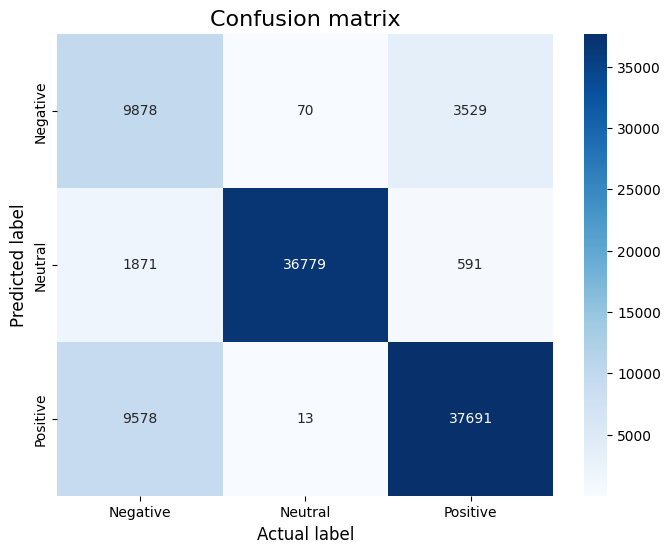

In [31]:
#Code Block 31
plot_confusion_matrix(model, X_test, y_test)

In [32]:
#Code Block 32
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

Accuracy  : 0.8435
Precision : 0.8515
Recall    : 0.8279
F1 Score  : 0.8395


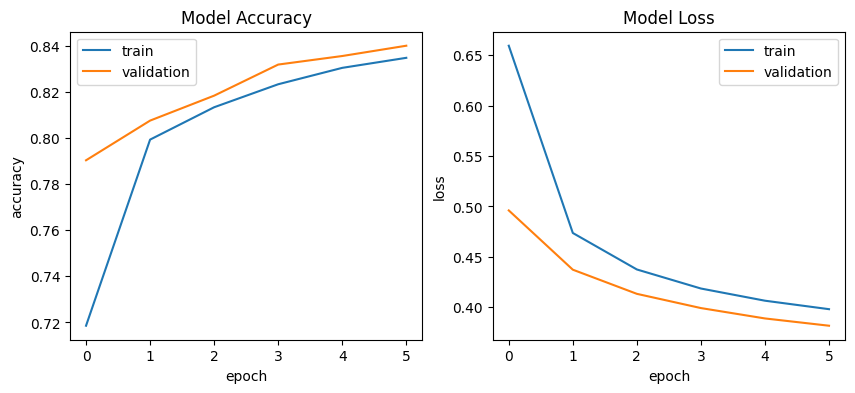

In [33]:
#Code Block 33
plot_training_hist(history)

# Our data prediction

In [35]:
#Code Block 34
def files_search(directory : 'str', extention : 'str') -> list:
    all_files = os.listdir(directory)    
    requested_files = list(filter(lambda f: f.endswith(extention), all_files))
    return requested_files

files = files_search(directory = 'sample_data/data', extention='xlsx')
frames = [pd.read_excel(f'sample_data/data/{file}') for file in files]


In [36]:
#Code Block 35
for i in range(len(files)):
    frames[i]['Ticker'] = files[i].replace('.xlsx', '')
    
data = pd.concat(frames)
data = data.drop_duplicates(subset = ['Text']).reset_index(drop = True)
print(f'Data Size: {data.shape[0]}x{data.shape[1]}')
data.head()

Data Size: 49820x7


,Text,Date,Likes,Comments,Retweets,Views,Ticker
0,RT @Johnnylee_DDC: GM @BoredApeYC HK Ape Gath...,29-01-2023 03:47:58,0,0,34,0,APEUSDT
1,RT @1putikbrown: with two legends @ocatanabing...,29-01-2023 03:47:14,0,0,12,0,APEUSDT
2,RT @cheezyxu: Just what a bored ape gonna do @...,27-01-2023 17:28:23,0,0,19,0,APEUSDT
3,RT @FvckingMeta: If you haven’t met @Timbaland...,26-01-2023 19:29:49,0,0,30,0,APEUSDT
4,RT @swap_suri: ape vape 🦧💨 @meleedose x @Bored...,26-01-2023 19:29:31,0,0,42,0,APEUSDT


In [37]:
#Code Block 36
df2 = data.copy()
df2 = df2.rename(columns = {'Text': 'text'})
df2 = parallelize_dataframe(df2, async_main_preprocessing)
df2 = parallelize_dataframe(df2, async_tweet_to_words)
df2['cleantext2'] = df2['words'].apply(lambda x: unlist(x))

# Tokenisation
X = tokenizer.texts_to_sequences(df2['cleantext2'])
X = pad_sequences(X, padding='post', maxlen=max_len)



24910it [1:26:39,  4.79it/s]  
24910it [1:26:39,  4.79it/s]  
24910it [1:29:02,  4.66it/s]
24910it [1:29:07,  4.66it/s] 


In [38]:
#Code Block 37
# Predictions
predictions = model.predict(X)
result = pd.DataFrame(predictions, columns = ['Negative', 'Neutral', 'Positive'])

data = pd.concat([data, result], axis = 1)
data['Class'] = np.argmax(predictions, axis=1)

names = pd.DataFrame(data = {'Class': [0, 1, 2], 'Sentiment' : ['Negative', 'Neutral', 'Positive']})
data = data.merge(names, how = 'left', on = ['Class'])
data = data.drop(columns = ['Class'])
for col in ['Negative', 'Neutral', 'Positive']:
    data[col] = np.round(data[col], 5)
data

1557/1557 [==============================] - 7s 4ms/step


,Text,Date,Likes,Comments,Retweets,Views,Ticker,Negative,Neutral,Positive,Sentiment
0,RT @Johnnylee_DDC: GM @BoredApeYC HK Ape Gath...,29-01-2023 03:47:58,0,0,34,0,APEUSDT,0.03265,0.95442,0.01293,Neutral
1,RT @1putikbrown: with two legends @ocatanabing...,29-01-2023 03:47:14,0,0,12,0,APEUSDT,0.17233,0.00025,0.82742,Positive
2,RT @cheezyxu: Just what a bored ape gonna do @...,27-01-2023 17:28:23,0,0,19,0,APEUSDT,0.32930,0.36133,0.30936,Neutral
3,RT @FvckingMeta: If you haven’t met @Timbaland...,26-01-2023 19:29:49,0,0,30,0,APEUSDT,0.05497,0.92535,0.01968,Neutral
4,RT @swap_suri: ape vape 🦧💨 @meleedose x @Bored...,26-01-2023 19:29:31,0,0,42,0,APEUSDT,0.02508,0.96308,0.01185,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
49815,Join EOS at London Fintech! https://t.co/OJyL...,16-06-2017 09:56:50,21,2,10,0,EOSUSDT,0.09243,0.00045,0.90712,Positive
49816,RT @rub3al3xand3r: Lots of logos + fractals in...,08-06-2017 20:35:27,0,0,5,0,EOSUSDT,0.03119,0.95804,0.01077,Neutral
49817,EOS presents! https://t.co/RFqE7c8Izx,22-05-2017 18:56:52,16,1,6,0,EOSUSDT,0.02595,0.96168,0.01237,Neutral
49818,"Official video to come, but check out #EOS at ...",22-05-2017 15:39:30,12,1,10,0,EOSUSDT,0.01731,0.97700,0.00568,Neutral


In [39]:
#Code Block 38
data.to_excel('sentiment_score.xlsx', index = False)

# finBERT

https://huggingface.co/yiyanghkust/finbert-tone

In [40]:
#Code Block 39
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.5 MB/s eta 0:00:00


In [41]:
#Code Block 40
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline, Trainer, TrainingArguments

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}
    
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [42]:
#Code Block 41
tokenized_texts = tokenizer(df2['cleantext'].to_list(),
                            truncation=True,
                            padding='max_length',
                            max_length=128
                           )

test_dataset = SimpleDataset(tokenized_texts)
trainer = Trainer(model=finbert)
predictions = trainer.predict(test_dataset).predictions

result = pd.DataFrame(predictions, columns = ['Neutral (finBERT)', 'Positive (finBERT)', 'Negative (finBERT)'])
names = pd.DataFrame(data = {'Class': [0, 1, 2], 'Sentiment (finBERT)' : ['Neutral', 'Positive', 'Negative']})

result['Class'] = np.argmax(predictions, axis=1)
result = result.merge(names, how = 'left', on = ['Class'])
result = result.drop(columns = ['Class'])
result.head()

,Neutral (finBERT),Positive (finBERT),Negative (finBERT),Sentiment (finBERT)
0,7.803725,-7.067989,-3.710370,Neutral
1,-1.052334,5.391204,-7.478100,Positive
2,8.345098,-7.964771,-4.133673,Neutral
3,5.040071,-6.115214,-2.105946,Neutral
4,7.187782,-6.120406,-4.313434,Neutral


# CryptoBert
https://huggingface.co/ElKulako/cryptobert

In [43]:
#Code Block 42
from transformers import AutoModelForSequenceClassification, AutoTokenizer

cryptobert = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")

In [44]:
#Code Block 43
tokenized_texts = tokenizer(df2['cleantext'].to_list(),
                            truncation=True,
                            padding='max_length',
                            max_length=64
                           )

test_dataset = SimpleDataset(tokenized_texts)
trainer = Trainer(model=cryptobert)
predictions = trainer.predict(test_dataset).predictions

result2 = pd.DataFrame(predictions, columns = ['Bearish (cryptoBERT)', 'Neutral (cryptoBERT)', 'Bullish (cryptoBERT)'])
names = pd.DataFrame(data = {'Class': [0, 1, 2], 'Sentiment (cryptoBERT)' : ['Bearish', 'Neutral', 'Bullish']})

result2['Class'] = np.argmax(predictions, axis=1)
result2 = result2.merge(names, how = 'left', on = ['Class'])
result2 = result2.drop(columns = ['Class']).head()
result2.head()

,Bearish (cryptoBERT),Neutral (cryptoBERT),Bullish (cryptoBERT),Sentiment (cryptoBERT)
0,-4.505219,1.553259,2.531914,Bullish
1,-5.259011,1.542148,3.527762,Bullish
2,-5.852648,2.055315,3.185068,Bullish
3,-4.992666,3.307590,0.953787,Neutral
4,-5.174720,1.966166,2.544008,Bullish


In [45]:
#Code Block 44
full_result = pd.concat([data, result, result2], axis = 1)
full_result.head()

,Text,Date,Likes,Comments,Retweets,Views,Ticker,Negative,Neutral,Positive,Sentiment,Neutral (finBERT),Positive (finBERT),Negative (finBERT),Sentiment (finBERT),Bearish (cryptoBERT),Neutral (cryptoBERT),Bullish (cryptoBERT),Sentiment (cryptoBERT)
0,RT @Johnnylee_DDC: GM @BoredApeYC HK Ape Gath...,29-01-2023 03:47:58,0,0,34,0,APEUSDT,0.03265,0.95442,0.01293,Neutral,7.803725,-7.067989,-3.710370,Neutral,-4.505219,1.553259,2.531914,Bullish
1,RT @1putikbrown: with two legends @ocatanabing...,29-01-2023 03:47:14,0,0,12,0,APEUSDT,0.17233,0.00025,0.82742,Positive,-1.052334,5.391204,-7.478100,Positive,-5.259011,1.542148,3.527762,Bullish
2,RT @cheezyxu: Just what a bored ape gonna do @...,27-01-2023 17:28:23,0,0,19,0,APEUSDT,0.32930,0.36133,0.30936,Neutral,8.345098,-7.964771,-4.133673,Neutral,-5.852648,2.055315,3.185068,Bullish
3,RT @FvckingMeta: If you haven’t met @Timbaland...,26-01-2023 19:29:49,0,0,30,0,APEUSDT,0.05497,0.92535,0.01968,Neutral,5.040071,-6.115214,-2.105946,Neutral,-4.992666,3.307590,0.953787,Neutral
4,RT @swap_suri: ape vape 🦧💨 @meleedose x @Bored...,26-01-2023 19:29:31,0,0,42,0,APEUSDT,0.02508,0.96308,0.01185,Neutral,7.187782,-6.120406,-4.313434,Neutral,-5.174720,1.966166,2.544008,Bullish


In [46]:
#Code Block 45
full_result.to_excel('sentiment_3_models.xlsx', index = False)